# Lesson: Bayesian Hierarchical Linear Regression

* Bayesian linear regressions are great, but similar to regular
* Hierarchical models are:
  - Very widely applicable (nested data very common)
  - Uniquely Bayesian
  - Higher accuracy, especially with small data
* Doorway to seeing the full power and flexibility of Bayesian modeling

Welcome to this next lesson on Hierarchical models. This is where things become really exciting. Up until now, you probably noticed the cool benefits of doing existing analyses, like linear regressions, in a Bayesian framework. However, it's also not *that* novel. Yes, we get better uncertainty than with frequentist statistics and can set priors, but we could not fundamentally do things we couldn't do without the Bayesian framework.

Well, this is about to change as hierarchical models are going to rock your world. This modeling structure is very powerful, widely applicable, and also very hard to do in other frameworks. So this is truly a super-power of the Bayesian approach. Most important of all, hierarchical models can improve the accuracy of your model, especially if you have few data points.

In addition, grocking the idea of hierarchical modeling is going to expand your mind to see the full potential and flexibility of Bayesian modeling. And if you think I'm hyping this up too much you're mistaken, these are the crown jewels right here. So strap in, lean back, and enjoy the ride.

## Use Cases
<center><img width=50% src="https://memegenerator.net/img/instances/86096861.jpg"/></center>

* Product categories
* User cohorts
* Marketing channels
* Geographical regions

So where can hierarchical models be used? Basically everywhere you have nested data. For example, if you have an online store with products nested into different categories. Probably the products inside of a category will share similarities, but still have individual differences. Hierarchical models are perfect for this.

Or say we are analyzing AB tests and different cohorts of users, we might also want to include the fact that these cohorts are likely to behave similarily into our model.

The same goes for marketing channels, or geographical regions. Basically whenever you have one or multiple groups in your data, hierarchical models can be interesting. It is pretty baffling to me that despite this being so common, only Bayesian modeling can realy make use of this pattern.

## Lesson Overview

### Why Hierarchical Regression
    - There are *similarities* between parameters of different groups
    - Pooled and unpooled models unsatisfying answer

## Distributions **Over Parameters**
- Estimating the estimates


### What Does the Hierarchy Actually Do?
    - Allows for modeling *similarities* but also *differences*
    - PyMC model with Bayesian workflow

### The Power of Bayes
  * What does the hierarchy actually *do*?
  * Smart regularization

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import warnings
from IPython.display import Image

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

# filter out Seaborn UserWarnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning,
    module=r'seaborn'
)

# Why Hierarchical Regression
Make the most out of your data

## Bayesian Hierarchical Regressions are Cool

<center><img src="https://memegenerator.net/img/instances/86111864.jpg"/></center>

OK, we just learned how amazing Bayesian regressions are, but we are going to take it one step further here. Let's dive in.

## Let's look at the data again

In [3]:
fish_market = pd.read_csv("data/fish-market.csv")
fish_market = fish_market.drop(["Length2", "Length3"], axis="columns")
fish_market["log_width"] = np.log(fish_market.Width)
fish_market["log_height"] = np.log(fish_market.Height)
fish_market["log_length"] = np.log(fish_market.Length1)
fish_market["log_weight"] = np.log(fish_market.Weight)
fish_reduced = fish_market[fish_market["Weight"] != 0].copy()
fish_market

/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Species,Weight,Length1,Height,Width,log_width,log_height,log_length,log_weight
0,Bream,242.0,23.2,11.5200,4.0200,1.391282,2.444085,3.144152,5.488938
1,Bream,290.0,24.0,12.4800,4.3056,1.459917,2.524127,3.178054,5.669881
2,Bream,340.0,23.9,12.3778,4.6961,1.546732,2.515905,3.173878,5.828946
3,Bream,363.0,26.3,12.7300,4.4555,1.494139,2.543961,3.269569,5.894403
4,Bream,430.0,26.5,12.4440,5.1340,1.635885,2.521239,3.277145,6.063785
...,...,...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,2.0904,1.3936,0.331890,0.737355,2.442347,2.501436
155,Smelt,13.4,11.7,2.4300,1.2690,0.238229,0.887891,2.459589,2.595255
156,Smelt,12.2,12.1,2.2770,1.2558,0.227773,0.822859,2.493205,2.501436
157,Smelt,19.7,13.2,2.8728,2.0672,0.726195,1.055287,2.580217,2.980619


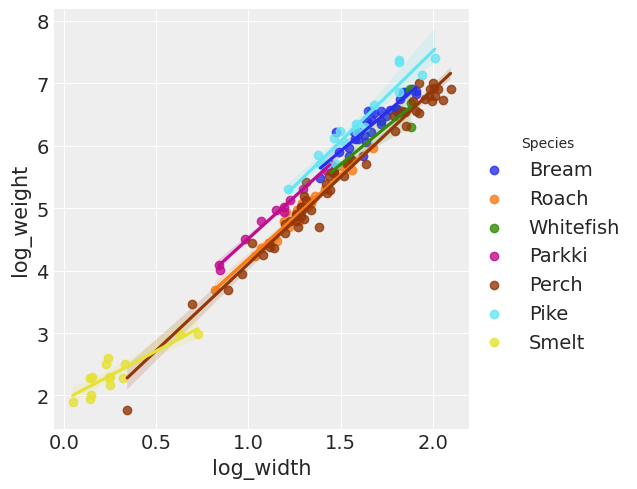

In [4]:
sns.lmplot(data=fish_reduced, x="log_width", y="log_weight", hue="Species",);

Let's load in the fish data from the linear regression module and plot them again. This time, however, I'm plotting all fish and their regression lines in the same plot.

Remember from before that Alex first built a model that fit a single regression to all fish species and found that it's not a good fit. He then fit separate regressions, like we're doing in this plot, which produced a much better fit.

But looking at the data, what do you think of that choice? Notice anything?

Yes, exactly, while the fish species aren't identical, they are pretty damn similar. I wonder why Alex did not notice that, I really worry about this guy sometimes. But don't worry, you're in good hands now.

## Two Lame Options

1. Pooled: Everything is identical
2. Unpooled: Everything is different and shares no similarities

We can clearly see that neither of these are true in this data.

<center><img width=25% src="https://i.imgflip.com/661i2t.jpg"/></center>

So to summarize, either we build a pooled model and assume all fish species are exactly the same, or we build an unpooled model that assumes they share no similarity at all.

But fear not, for our dear Reverend Thomas Bayes comes to bust us out of this pickle once again and offer a third way.

<center><img src="https://miro.medium.com/max/920/1*_i4uVp43apgOMpHRw6WG-w.jpeg"></center>

# Distributions **Over Parameters**

What all the cool kids are doing these days.

OK, welcome back! In this section we will get a better understanding of what the similarities look like in terms of the actual parameters. To do that, let's run the unpooled model from the previous section. 

Note, that to make the code simpler, we will now only consider a single predictor, rather than all three. The predictor we will use is the width, but it doesn't matter which one we pick.

In [5]:
fish_test = fish_reduced.sample(frac=0.1, random_state=RANDOM_SEED).sort_index()
test_idx = fish_test.index
fish_train = fish_reduced.loc[fish_reduced.index.difference(test_idx)]

species_idx, species = fish_train.Species.factorize(sort=True)
COORDS = {
    "slopes": ["width_effect"], #, "height_effect", "length_effect"],
    "species": species,
}

COORDS

{'slopes': ['width_effect'],
 'species': Index(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'], dtype='object')}

## Unpooled Model

In [24]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_unpooled:
    # data
    log_width = pm.MutableData("log_width", fish_train.log_width.values)
    log_weight = pm.MutableData("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

    # priors
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims=("species"))

    # linear regression
    mu = pm.Deterministic("mu", intercept[species_idx_] + β[species_idx_] * log_width)
    
    # observational noise
    sigma = pm.HalfNormal("sigma", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=sigma,
        observed=log_weight,
    )

    # sampling
    idata_unpooled = pm.sample()
    idata_unpooled.extend(pm.sample_prior_predictive())
    idata_unpooled.extend(pm.sample_posterior_predictive(idata_unpooled))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, sigma]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


This is basically the same model you've seen in the last section, so I'm not going to go over it again.

Rather, let's look at the different intercept and beta parameters.

## Extract Posterior Means

In [51]:
df_plot = (idata_unpooled
           .posterior[["intercept", "β"]]
           .mean(("chain", "draw"))
           .to_dataframe()
           .rename_axis(columns="parameters")
           .stack()
           .reset_index()
           .rename(columns={0: "mean"})
          )
df_plot

,species,parameters,mean
0,Bream,intercept,2.412584
1,Bream,β,2.342613
2,Parkki,intercept,2.418754
3,Parkki,β,2.146039
4,Perch,intercept,1.342585
5,Perch,β,2.775624
6,Pike,intercept,2.218909
7,Pike,β,2.584988
8,Roach,intercept,1.922721
9,Roach,β,2.362836


## Histogram Over Intercepts And Slopes

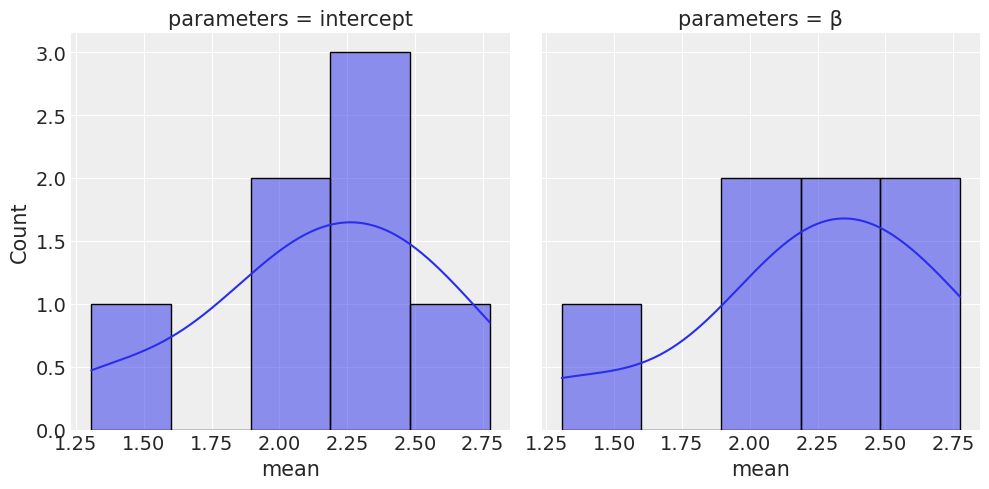

In [26]:
sns.displot(df_plot, x="mean", col="parameters", kde=True);

OK, what I did here was to extract the posterior means of each of the species' intercept and beta parameters.

I know it's just a couple of points, but what does that look like to you?

Well the first thing to note is that the values are clustered around a common value, they are very similar like we already saw from looking at the data.

So how would you describe this data? Right, exactly, with a distribution. And the kernel density estimate makes it look like it could be a Normal distribution.

## Distributions Over Parameters

<center><img src="https://memegenerator.net/img/instances/86091597.jpg"/></center>

* Old: specify a distribution over data points 
* New: specify a distribution over **a group of parameters**.

OK, so here is the central concept. Just like we can say that a set of data points is, for example, normally distributed, we can do the same for a group of parameters, in this case, the intercepts and slopes of the different fish.

This insight has far-reaching consequences and allows us to build highly complex models.

In the next section we will see how we can express this idea in PyMC.

## Hierarchical Models In PyMC

In [59]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_hierarchical:
    # data
    log_width = pm.MutableData("log_width", fish_train.log_width.values)
    log_weight = pm.MutableData("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.MutableData("species_idx", species_idx)

This should look very familiar, we just define our data containers and make them mutable so that you can replace their values in the homework.

## Intercept Hierarchical Model

In [60]:
with fish_hierarchical:
    # hierarchy on intercepts
    intercept_mu = pm.Normal("intercept_mu", sigma=3.0)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=1.0)
    
    # individual intercepts for each species
    intercept = pm.Normal("intercept", 
                          mu=intercept_mu,
                          sigma=intercept_sigma, 
                          dims="species")

Here are finally where things get interesting. Let's start at the bottom. We can again have our intercept parameters across the species dimension. However, instead of setting mu and sigma to fixed values as before, we now replace those with other parameters we are also going to estimate.

Looking at the lines above, this is where we specify the priors for the mean and standard deviation of the species intercepts. Because we know that the intercepts can deviate quite far from zero, I chose a standard deviation of 3 for the intercept mean. And for the sigma parameter I pick a HalfNormal, because standard devations can only be positive. I pick a smaller `sigma` of 1 because the intercepts are all pretty close together.

Of course, when creating this model using the full Bayesian workflow as you've seen in the previous lesson, we would run predictive checks to determine these values.

## Beta Hierarchical Model

In [61]:
with fish_hierarchical:
    # hierarchy on betas
    β_mu = pm.Normal("β_mu", sigma=3.0)
    β_sigma = pm.HalfNormal("β_sigma", sigma=1.0)
    
    # individual betas for each species
    β = pm.Normal("β", 
                  mu=β_mu, 
                  sigma=β_sigma, 
                  dims=("species"))

Next, we do the same for the betas. You can just imagine that the individual betas are data points we have observed and we want to estimate their mean and standard deviation. Of course, we also estimate the individual betas here, and they will get estimated together with their mu and sigma parameters together.

And you might be wondering right now, don't the individual beta estimates depend on the mu and sigma estimates? And don't the mu and sigma estimates in turn depend on the individual beta estimates? Yes, indeed, but it's not a problem for our powerful sampling algorithm which just figures this whole thing out for us.

## Linear Regression

In [62]:
with fish_hierarchical:
    # linear regression
    mu = intercept[species_idx_] + β[species_idx_] * log_width

Now everything else in the model is exactly as before, we define our regression estimate.

## Likelihood and Error Term

In [63]:
with fish_hierarchical:
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)
    
    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )

And then we define our likelihood function after defining our error term.

## Model Structure

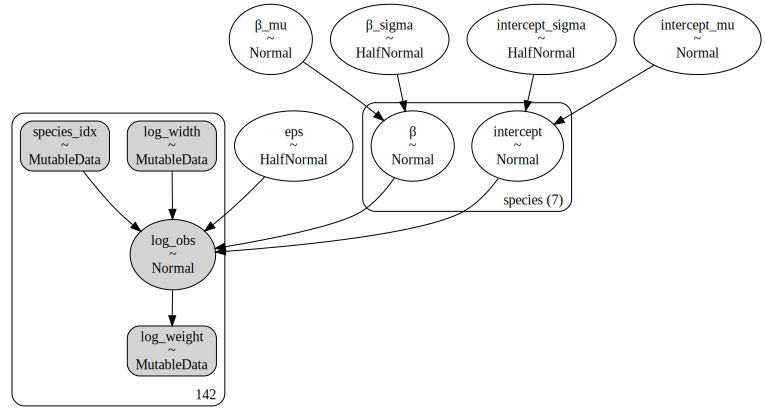

In [64]:
pm.model_to_graphviz(fish_hierarchical)

Looking at the model overview we can see that beta and intercept now have overarching distributions.

## Hitting the Inference Button (TM)

In [46]:
with fish_hierarchical:
    # Hit the Inference Button(TM)
    idata_hierarchical = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_intercept_mu, group_intercept_sigma, intercept, group_β_mu, group_β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


And now my usual favorite part: no math! We just hit our inference button and are on our way.

However, sometimes things do not go quite so smoothly, as we get informed about a divergence. This is a region where the sampler is having difficulties and is not sampling correctly. If there are just a handful of divergences, say less than 5 it's usually nothing to worry about, but I wanted to show you how we can sometimes just improve the situation by increasing the `target_accept` parameter.

## Increasing `target_accept` to Get Rid of Divergences

In [67]:
with fish_hierarchical:
    # Hit the Inference Button(TM)
    idata_hierarchical = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, intercept_sigma, intercept, β_mu, β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


As you can see, setting `target_accept` to `0.95` gets rid of the divergence. Under the hood, this causes the sampler to explore the posterior more accurately at the cost of speed. You can usually start with setting it first to `0.85`, then `0.9`, then `0.95` and finally to `0.99`. 

If that does not help, probably your model is wrong.

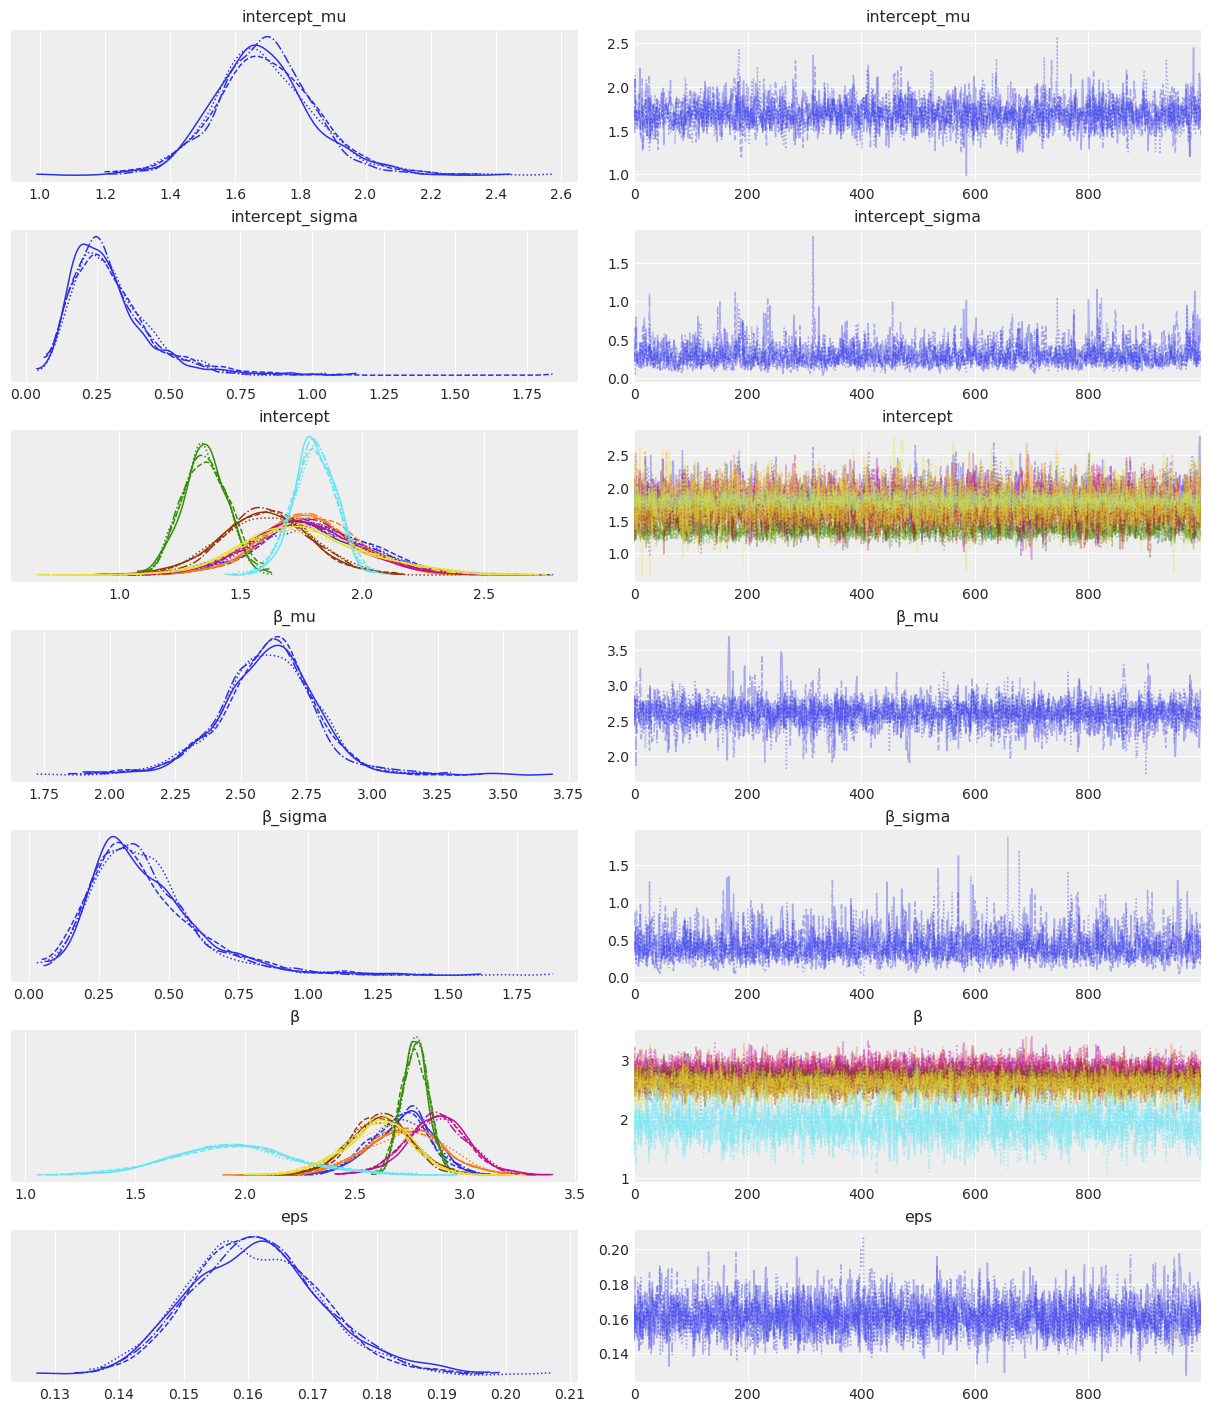

In [68]:
az.plot_trace(idata_hierarchical);

Here our posterior chains all look good -- nice!

## Section Summary

* Instead of `pm.Normal("x", 0, 1, dims="d")` ➞ `pm.Normal("x", mu, sigma, dims="d")`
* Divergences indicate problems with the model
* Increase `target_accept` to get rid of small divergences

Alright, in this section we've seen how instead of having a vector of Normal variables centered around a fixed value, we can also *estimate* the group mean and standard deviations by adding parameters with their own priors on them.

What's cool is that the rest of the model as well as the inference stayed the same, this is the power of the modular toolbox approach of Bayesian modeling where we can iteratively add structure to our models to improve them.

However, this model is more complex to sample from and our sampler had some issues. This should cause us to take a look at the model if something is wrong, but if it's just a small number of divergences, we can usually just make the sampler go slower by increasing `target_accept`.

# What Does the Hierarchy Actually Do?

* Concept of "smart priors"
* Effects on regression lines and posteriors
* What happens to esimate with many and few data points
* Concept of "smart regularization"

In this section we will take a look at what introducing the hierarchy into our model actually *does*. We will look at through different lenses. First, I will introduce the concept of smart priors. Next, we'll look at what effect this has on the regression lines and on the actual posteriors.

This builds up our intutions around why hierarchies are so cool and how they are affected by the number of data points per group. This will then lead us to the concept of "smart regularization".

In [69]:
def plot_pred(idata, species="Whitefish", color="0.5", label="", ax=None):
    """
    Helper function to plot regression lines from the posterior on top of data points.
    """
    fish_spec = fish_reduced[fish_reduced.Species == species]
    x_lower = fish_spec["log_width"].min() - .5
    x_upper = fish_spec["log_width"].max() + .5
    x = np.linspace(x_lower, x_upper, 150)
    
    ys = []
    if ax is None:
        fig, ax = plt.subplots()
        ax.scatter(fish_spec["log_width"], fish_spec["log_weight"], color="k")
        
    y = idata.posterior["intercept"].sel(species=species).mean(("chain", "draw")).data + (x * idata.posterior["β"].sel(species=species).mean(("chain", "draw")).data)
    ax.plot(x, y, color=color, alpha=.8, lw=3, label=label)
    
    for count, i in enumerate(range(100, 150)):
        y = idata.posterior["intercept"].sel(species=species, chain=0, draw=i).data + (x * idata.posterior["β"].sel(species=species, chain=0, draw=i).data)
        ys.append(y)
        ax.plot(x, y, color=color, alpha=.1)
        
    ax.set(xlabel="log_width", ylabel="log_weight", 
           title=f"Regression lines for {species}")
    
    if label != "":
        ax.legend()
        
    return ax

## How Much Data Do We Have for Every Species?

In [21]:
fish_reduced.groupby("Species").count()["Weight"].sort_values()

Species
Whitefish     6
Parkki       11
Smelt        14
Pike         17
Roach        19
Bream        35
Perch        56
Name: Weight, dtype: int64

First, let's note something about the data set we've been working with. As you can see from the counts, for some fish, like Perch, we have many measurements, while for others, like Whitefish we only have a few data points.

Hierarchical models have a specific effect depending on how much data we have per group, so in this section we will look at what the hierarchical model does to the extreme cases of Whitefish and Perch.

## "Smart Priors"

* Unpooled: `β = pm.Normal("β", mu=0, sigma=1, dims=("species"))`
* Hierarchical: `β = pm.Normal("β", mu=β_mu, sigma=β_sigma, dims=("species"))`

Both provide *regularization*, one to `0` in a fixed way, the other to the **group mean** in a dynamic, data-dependent way. We **learn** the prior.

As we discussed before, we replace the fixed values in our species parameters with parameters that we estimate. So instead of a fixed prior we have something similar but something we learn from the data. Note that we do not just learn the mean but also *how strong we want to shrink values to that mean* with the sigma parameter.

Let's look at this further to build our intuitions.

## Regression Lines Unpooled Model

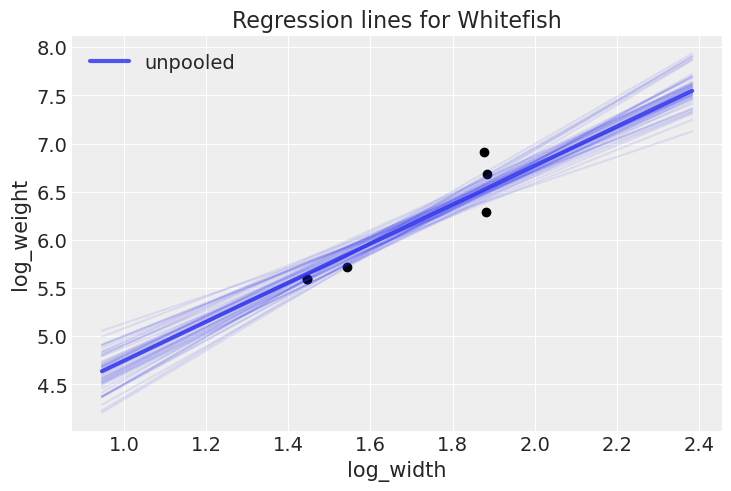

In [27]:
plot_pred(idata_unpooled, label="unpooled", color=sns.color_palette()[0]);

Here we see the regression lines for the unpooled model. The thick line is the mean while the lighter lines are individual draws from the posterior to give a sense of uncertainty. 

As you can see, we do not have a lot of data for Whitefish so our uncertainty is quite high: many regression lines could explain this data reasonably well.

Let's look at what happens in the hierarchical model.

## Regression Lines Hierarchical Model

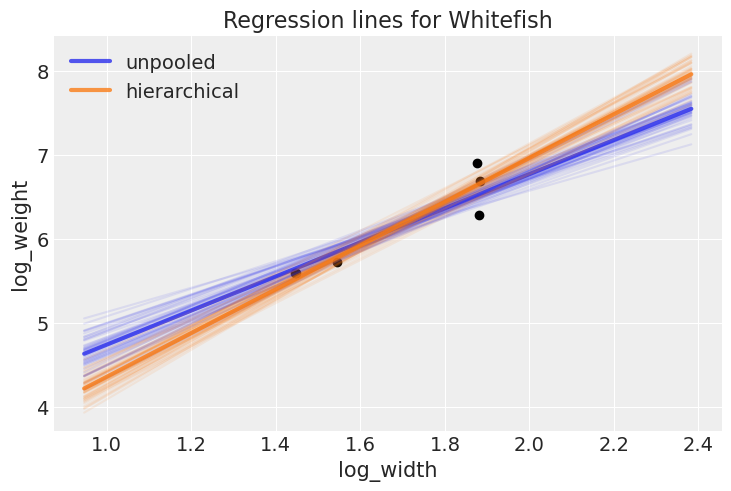

In [28]:
ax = plot_pred(idata_unpooled, label="unpooled", color=sns.color_palette()[0])
plot_pred(idata_hierarchical, label="hierarchical", color=sns.color_palette()[1], ax=ax);

Interesting, the line definitely changed. What are the two obvious changes?

Exactly, the intercept and slopes are both different, but also, the *uncertainty* is lower indicated by the lines being narrower around the mean.

Why is that happening? Let's look at the posteriors next to see what's going on.

## Posterior Unpooled vs Hierarchical

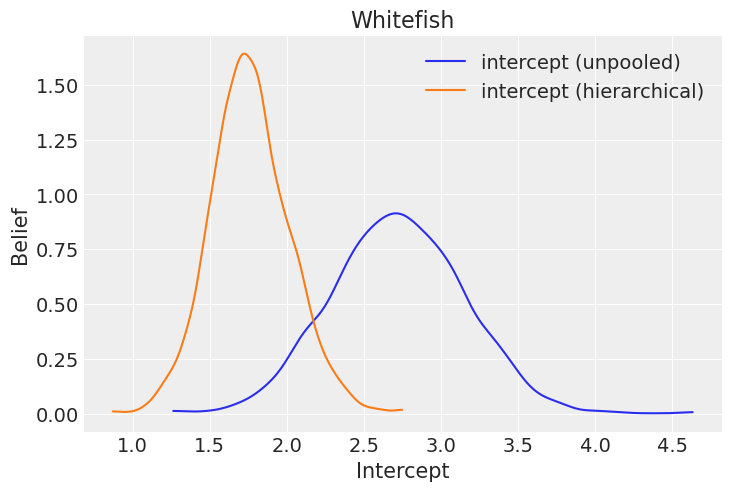

In [29]:
az.plot_dist(idata_unpooled.posterior.intercept.sel(species="Whitefish"), color=sns.color_palette()[0], label="intercept (unpooled)")
az.plot_dist(idata_hierarchical.posterior.intercept.sel(species="Whitefish"), color=sns.color_palette()[1], label="intercept (hierarchical)")
plt.xlabel("Intercept"); plt.ylabel("Belief"); plt.title("Whitefish");

Let's compare the posteriors between the two models. 

1. The intercept posterior of the unpooled model;
2. The intercept posterior of the hierarchical model.

What do you see?

One thing we notice is that indeed the uncertainty of the hierarchical intercept is lower than that of the unpooled model, which mirrors what we've seen on the previous plot. It's also estimated lower. But why is that the case? Where is that increased certainty and the lower estimate coming from?

## Regularization Towards the Mean

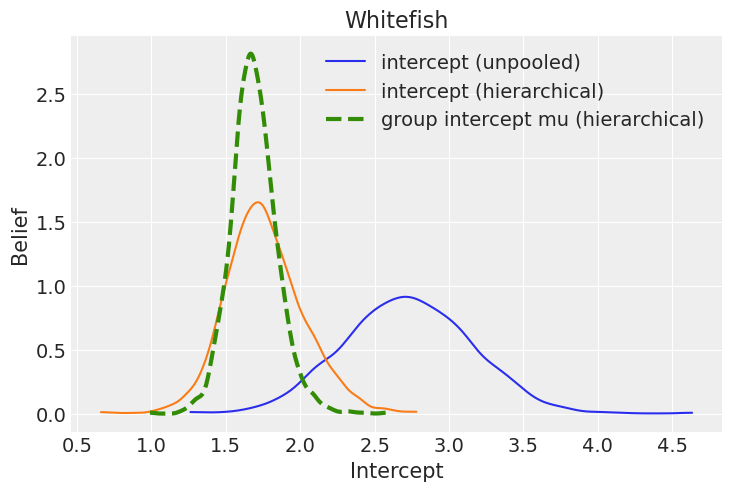

In [74]:
az.plot_dist(idata_unpooled.posterior.intercept.sel(species="Whitefish"), color=sns.color_palette()[0], label="intercept (unpooled)")
az.plot_dist(idata_hierarchical.posterior.intercept.sel(species="Whitefish"), color=sns.color_palette()[1], label="intercept (hierarchical)")
az.plot_dist(idata_hierarchical.posterior.intercept_mu, color=sns.color_palette()[2], plot_kwargs=dict(ls="--", lw=3.0), label="group intercept mu (hierarchical)")
plt.xlabel("Intercept"); plt.ylabel("Belief"); plt.title("Whitefish");

Exactly! It's being pulled down by the mean, as you can see now that I add the group intercept mu parameter of the hierarchical model.

Also, note that having the group mean estimate is useful in itself. In the unpooled model we did not have direct access to the group mean.

## Beta (Slope) Posteriors

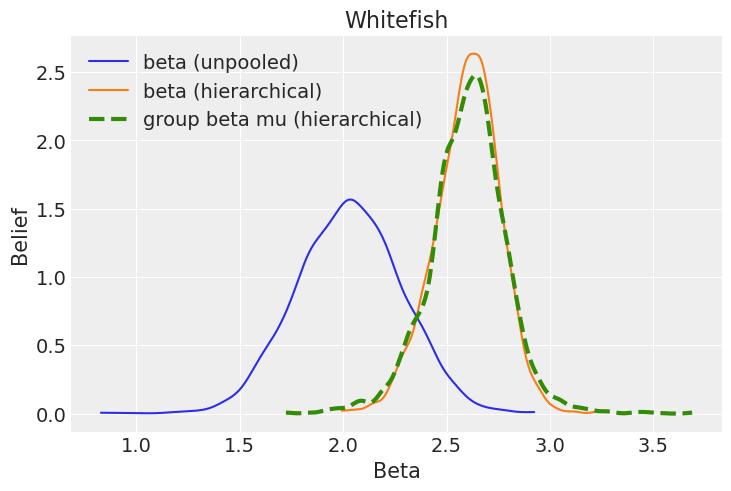

In [75]:
az.plot_dist(idata_unpooled.posterior.β.sel(species="Whitefish"), color=sns.color_palette()[0], label="beta (unpooled)")
az.plot_dist(idata_hierarchical.posterior.β.sel(species="Whitefish"), color=sns.color_palette()[1], label="beta (hierarchical)")
az.plot_dist(idata_hierarchical.posterior.β_mu, color=sns.color_palette()[2], plot_kwargs=dict(ls="--", lw=3.0), label="group beta mu (hierarchical)")
plt.xlabel("Beta"); plt.ylabel("Belief"); plt.title("Whitefish");

And looking at the beta parameter posteriors we see the same pattern.

## Let's Look at Perch

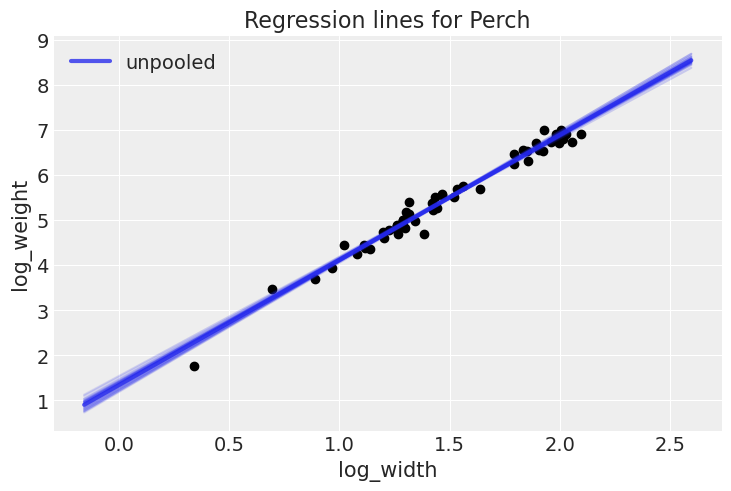

In [36]:
plot_pred(idata_unpooled, species="Perch", color=sns.color_palette()[0], label="unpooled");

OK, here we can see that there are many more data points and even the unpooled model is pretty certain about plausible regression lines.

Let's look at what the hierchical model says.

## Hierarchical and Unpooled side by side

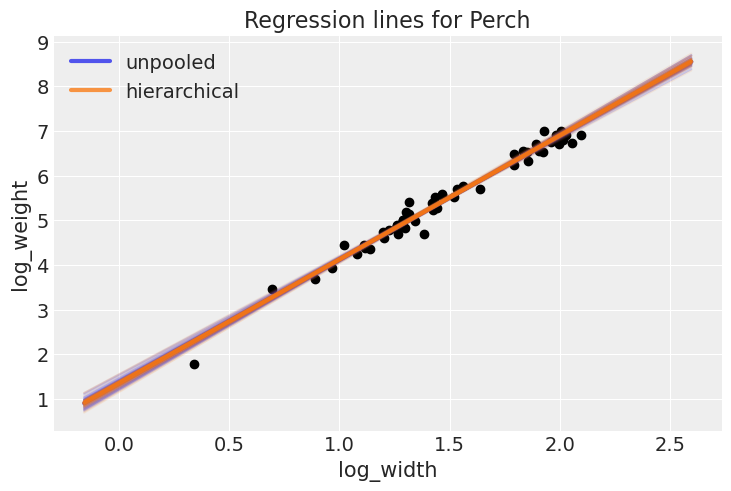

In [37]:
ax = plot_pred(idata_unpooled, species="Perch", color=sns.color_palette()[0], label="unpooled");
plot_pred(idata_hierarchical, species="Perch", color=sns.color_palette()[1], label="hierarchical", ax=ax);

Interesting, right? The two are almost identical. So it seems like the hierarchy does not have a big influence on the regression for Perch. Let's look next at the posteriors.

## And Now for the Posteriors...

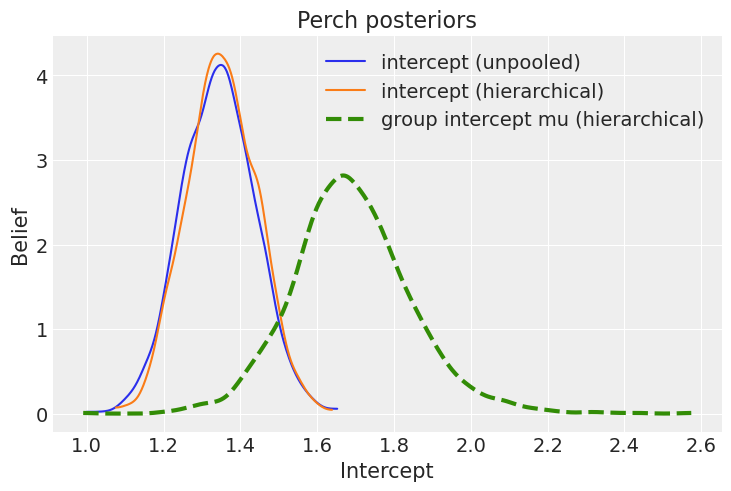

In [76]:
az.plot_dist(idata_unpooled.posterior.intercept.sel(species="Perch"), color=sns.color_palette()[0], label="intercept (unpooled)")
az.plot_dist(idata_hierarchical.posterior.intercept.sel(species="Perch"), color=sns.color_palette()[1], label="intercept (hierarchical)")
az.plot_dist(idata_hierarchical.posterior.intercept_mu, plot_kwargs=dict(ls="--", lw=3.0),  color=sns.color_palette()[2], label="group intercept mu (hierarchical)")
plt.xlabel("Intercept"); plt.ylabel("Belief"); plt.title("Perch posteriors");

What do you see here? What's different compared to the posteriors for Whitefish?

Yes, the posteriors for the unpooled and hierarchical model are almost identical, the group intercept mu has almost no influence. 

## And for The Beta Parameters...

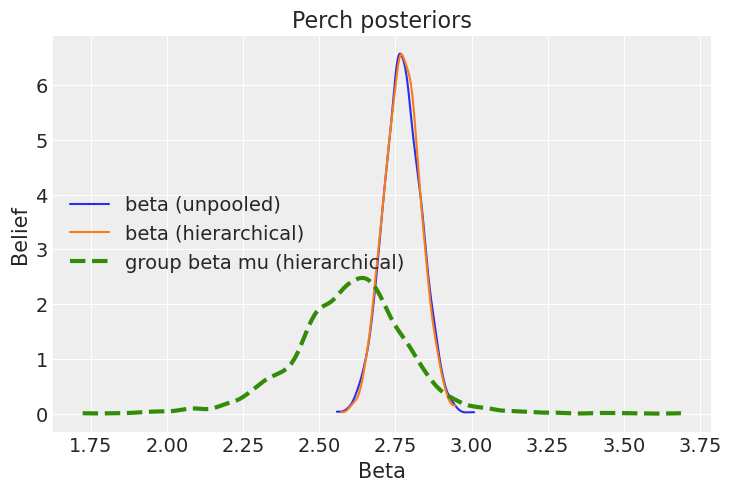

In [77]:
az.plot_dist(idata_unpooled_oos.posterior.β.sel(species="Perch"), color=sns.color_palette()[0], label="beta (unpooled)")
az.plot_dist(idata_hierarchical.posterior.β.sel(species="Perch"), color=sns.color_palette()[1], label="beta (hierarchical)")
az.plot_dist(idata_hierarchical.posterior.β_mu, plot_kwargs=dict(ls="--", lw=3.0), color=sns.color_palette()[2], label="group beta mu (hierarchical)")
plt.xlabel("Beta"); plt.ylabel("Belief"); plt.title("Perch posteriors");

Looking at the posteriors for beta we see the same pattern.

## Section Summary

* Shrinkage towards the mean
* Group estimate ⟷ individual estimates
* Few data points ➞ strong shrinkage
* Many data points ➞ weak shrinkage
* ➞ Smart regularization

So to summarize, in this section we looked at what effect the hierarchy has on the model estimates, compared to the unpooled model that shares no information between different fish. What the hierarchy does is estimate a mean and standard-deviation of how the  intercepts and betas of the different fish species are distributed. These resulting "smart priors" that are learned from data then have a regularizing effect on the individual estimates: just like regular priors they provide shrinkage, in this case they shrink towards the group mean. 

So you can see how they constrain each other: the individual betas are used to estimate the group parameters, while the group parameters are used to constrain the individual betas. And our Bayesian framework is smart enough to figure out exactly the ideal interplay between them.

But you've also seen that this shrinkage towards the mean does not happen statically. In the case of few data points like for Whitefish we saw a strong shrinkage effect, while in the case where we had many data points like for Perch the group distribution had almost no effect. That's why I called this here "smart regularization".

It is worth noting that nothing magical is going on here either. As I mentioned before, we can think of the hierarchy as "smart priors". And just like with regular priors, the prior is easily overwhelmed by data, and in the case of Perch we have enough data to overwhelm our "smart prior".

# The Power of Bayes

Hierarchical models great example of the benefits

OK, in this last section I want to perform the final step of our inception where we are diving deeper than one layer into our modeling. This hierarchical linear regression is really cool, right? I hope while going through this you already had ideas of where you can apply this to your own problems.

However, we are not constrained to just this particular pattern. We can place hierarchies in all kinds of models, not just regressions. If you run multiple AB tests for example, you can put those into a hierarchy. 

## Hierarchical Time-Series
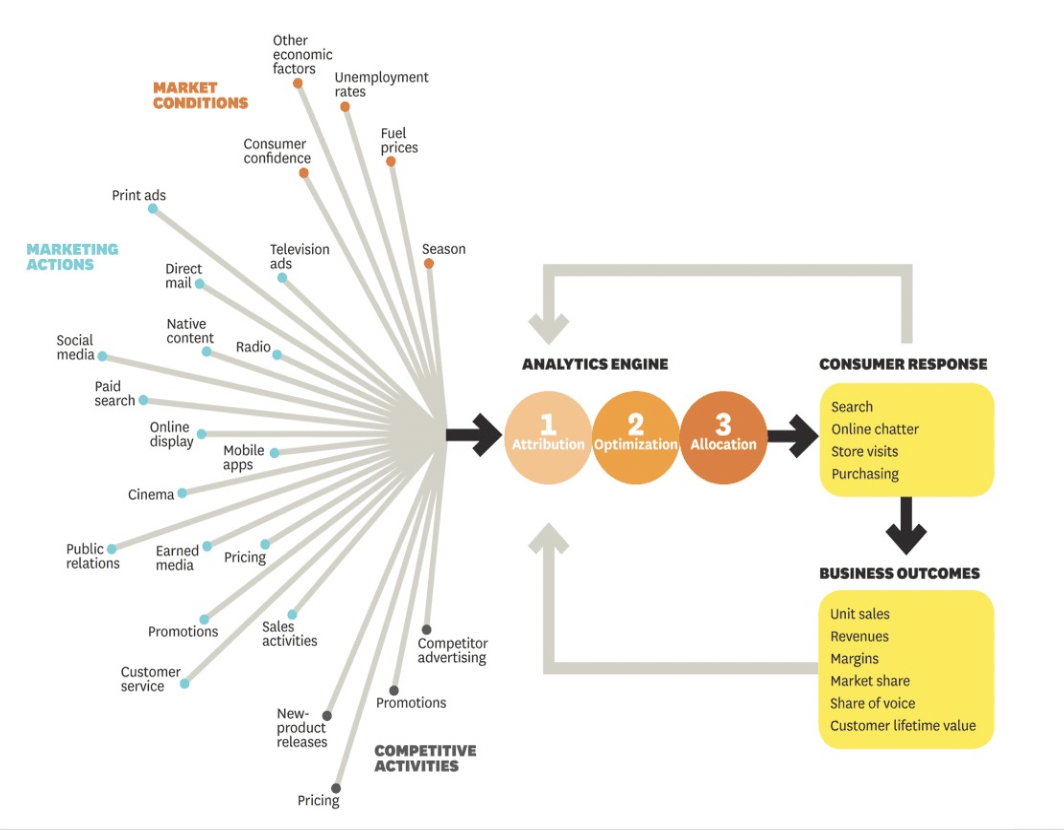

Or coming back to Bayesian Media Mix Model I showed you briefly at the very beginning. Different marketing channels like Online or TV Ads are actually changing over time, so in our work with HelloFresh, the multi-million dollar food delivery company, we placed a time-varying distribution on them. But all ad channels also share similarity in *how* they change over time. So we place a hierarchical time-varying group-distribution over the different ad channels.

## Plugging Parameters Into Parameters

<table><tr>
<td><img width=100% src="https://parenthesis-info.org/wp-content/uploads/2019/05/Traditional_Russian_Matryoshka.jpg"></td>
<td><img width=100% src="https://1.bp.blogspot.com/-wiuOhBdx6Ug/V0IpKOUiSpI/AAAAAAAAfYc/fnXs_qvt64sRAZTqdoRFL294Q8Q86XtogCLcB/s1600/russian-doll-train-ticket.jpg"/></td>
    </tr>
</table>
    

But hierarchies are just one pattern. Really the key insight is that we can input parameters into other parameters and build insanely complex models this way. This Russian doll approach also plays a big role when we think about generative modeling.

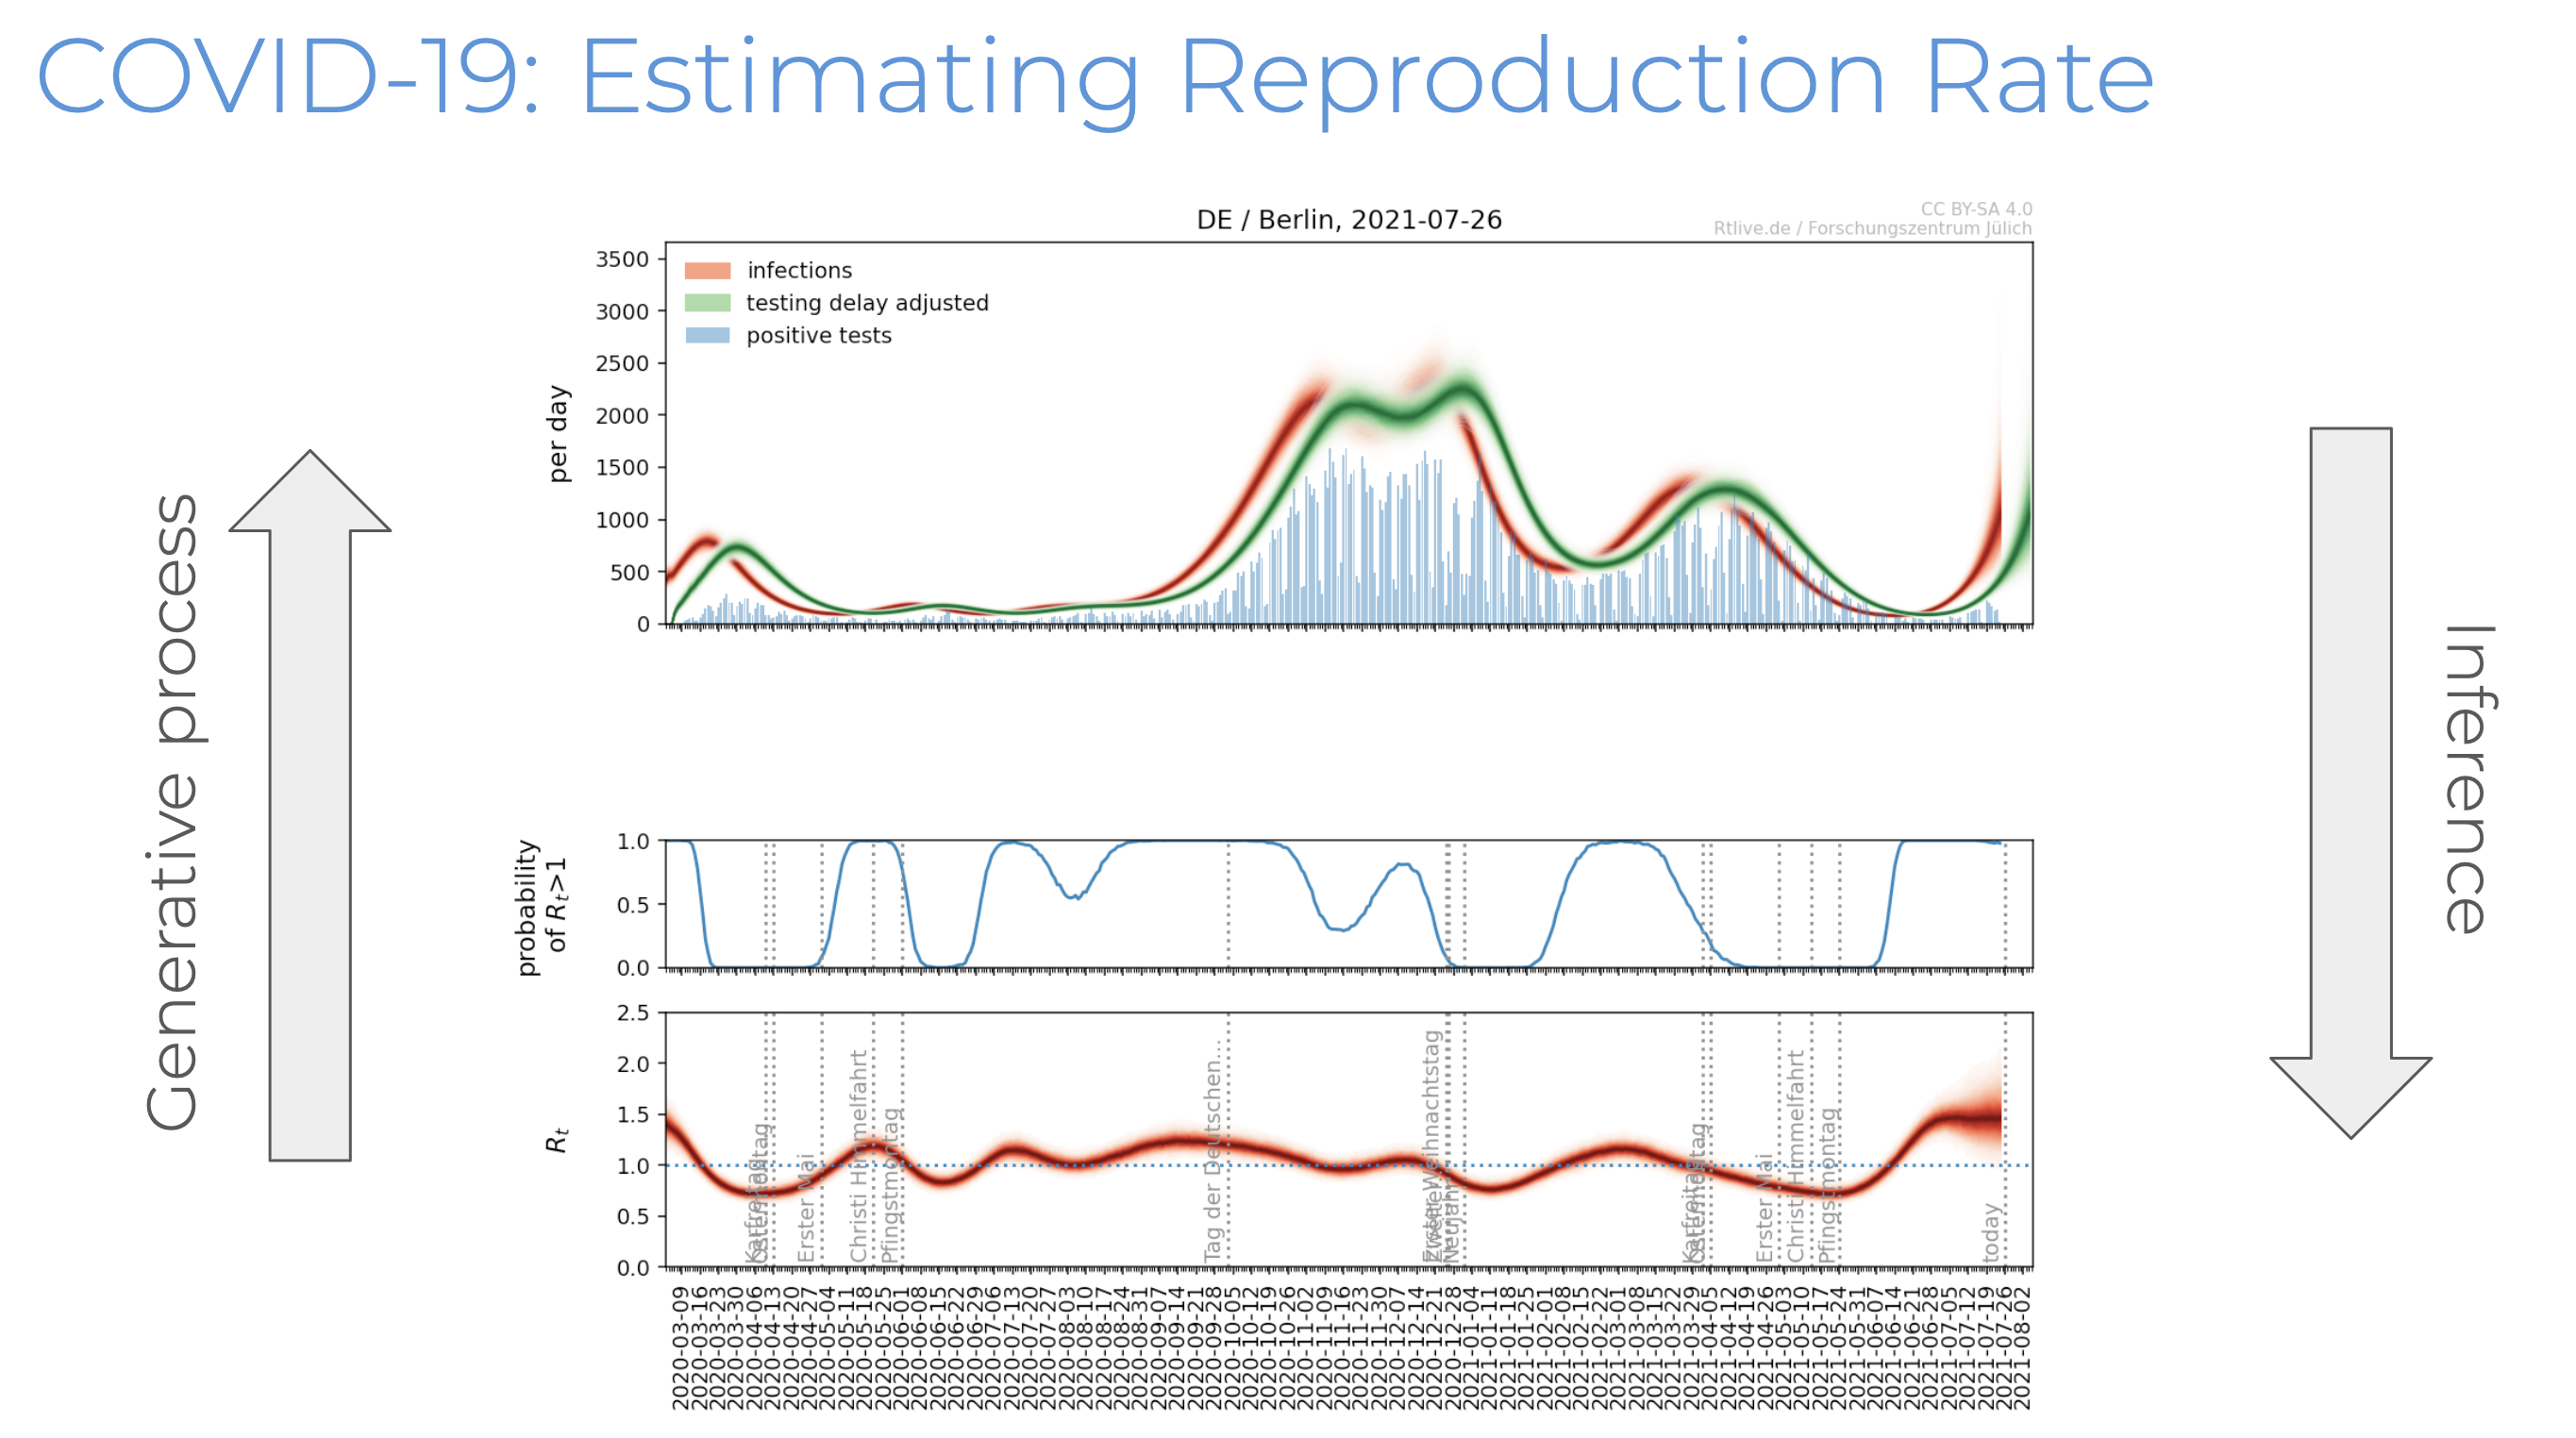

Remember this slide from the introduction? There we made heavy use of this principle of plugging parameters into other parameters to model the generative process. One person was infecting a certain number of other people, then these have an incubation period, as well as a period where they develop symptoms, and then finally get a test that then shows up in our data set. At every step we chain parameters into parameters.

## What Does That Mean For Our Business?

* Hierarchical models *usually* have higher accuracy
* Especially for those species where we have few data points
* Higher accuracy ➞ higher revenue

## Section Summary

* Hierarchies can be used widely
* Plugging parameters into other parameters adds lots of flexibility

# Lesson Summary

* Pooled and unpooled models unsatisfactory
* Species parameters are distributed normally
  -  Place normal distribution on species parameters
* Acts as "smart prior" that is learned from data
* Provides smart regularization based on number of data points
* Stacking parameters allows for great model flexibility

Alright, so to summarize this lesson, we started by seeing how being forced to treat species parameters as either being identical, like in a pooled model, or completely separate, like in an unpooled model is unsatisfactory.

We then looked at how the intercepts and betas of the different species were distributed and saw that they can be described via a normal distribution. In PyMC this is quite easy to implement.

I then showed you what the hierarchy actually adds to our inference. By thinking about them like a smart prior that gets learned from the data, we saw that if you have few data points, you get a lot of regularization, while if you have many data points, the group distribution has little influence on our species estimate. This is what I call *smart regularization* here.

Finally, I showed you how this idea of stacking parameters over other parameters is a very powerful idea that allows us to build all kinds of complicated models that accuratey map a business problem to a statistical model.

# Backup

In [ ]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_hierarchical_nc:
    # data
    log_width = pm.Data("log_width", fish_train.log_width.values)
    log_height = pm.Data("log_height", fish_train.log_height.values)
    log_length = pm.Data("log_length", fish_train.log_length.values)
    log_weight = pm.Data("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.Data("species_idx", species_idx)

    # priors
    group_intercept_mu = pm.Normal("group_intercept_mu", sigma=5.0)
    group_intercept_sigma = pm.HalfNormal("group_intercept_sigma", sigma=.1)
    intercept = pm.Normal("intercept", dims="species") * group_intercept_sigma + group_intercept_mu
    
    group_β_mu = pm.Normal("group_β_mu", sigma=3.5)
    group_β_sigma = pm.HalfNormal("group_β_sigma", sigma=.05)
    β = pm.Normal("β", mu=group_β_mu, sigma=group_β_sigma, dims=("species", "slopes")) #*  + group_β_mu

    # linear regression
    mu = (
        intercept[species_idx_]
        + β[species_idx_, 0] * log_width
        + β[species_idx_, 1] * log_height
        + β[species_idx_, 2] * log_length
    )
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )

    # sampling
    idata_hierarchical = pm.sample(init="jitter+adapt_diag", tune=1000, target_accept=0.9)
    idata_hierarchical.extend(pm.sample_prior_predictive())
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

In [ ]:
with fish_unpooled_oos:
    # update values of predictors:
    pm.set_data(
        {
            "log_height": fish_test.log_height.values,
            "log_length": fish_test.log_length.values,
            "log_width": fish_test.log_width.values,
            "species_idx": fish_test.Species.factorize(sort=True)[0],
        }
    )

Once that's done, we can just call `sample_posterior_predictive`. The only difference is that we're telling PyMC these are really predictions (`predictions=True`), and we want them appended to our existing `InferenceData` object (`extend_inferencedata=True`).

In [ ]:
with fish_unpooled_oos:
    # use the updated values to predict outcomes:
    idata_unpooled_oos = pm.sample_posterior_predictive(
        idata_unpooled_oos,
        predictions=True,
        extend_inferencedata=True,  # not released yet, needs main branch
    )

In [ ]:
az.plot_posterior(
    idata_unpooled_oos.predictions,
    ref_val=fish_test["Weight"].tolist(),
    transform=np.exp,
);

### Section recap

- Use `pm.set_data` to update the values of predictors
- `pm.sample_posterior_predictive(predictions=True, extend_inferencedata=True)` uses the updated values to predict outcomes and appends them to the original `InferenceData` object
- `az.plot_posterior` is an easy and concise way to check the quality of and uncertainty in those predictions